* In this assignment you will be using the entire transformer architecture for a translation task.
* we will just be using one encoder layer and one decoder layer
* You can copy the encoder and decoder modules from the previous assignments. You are going to translate a few sentences from **English to Tamil**
  * Source language: English
  * Target language: Tamil

* You may experiment with a target language of your choice for checking the impelementation. (You may use google translate for that)

* We need to install torchdata and torchtext (which take about 3 minutes to finish installing) for tokenizing the text.
* We already defined useful functions for the tokenization of texts




In [1]:
!pip install torchdata==0.6.0 # to be compatible with torch 2.0
!pip install portalocker==2.0.0
!pip install -U torchtext==0.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

* Let's import all required libraries

In [2]:
import time
import copy
import matplotlib.pyplot as plt

import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

#text lib
import torchtext

# tokenizer
from torchtext.data.utils import get_tokenizer

#build vocabulary
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator

# get input_ids (numericalization)
from torchtext.transforms import VocabTransform, LabelToIndex

# get embeddings
from torch.nn import Embedding

import torch.nn.init as init

from  pprint import pprint
from yaml import safe_load
import copy
import numpy as np
import requests
import math

# Preparing Data

* Source and target text

In [3]:
src_text = """The most famous ruler of ancient India was Emperor Ashoka.
It was during his period that Buddhism spread to different parts of Asia.
Ashoka gave up war after seeing many people grieving death after the Kalinga war.
He embraced Buddhism and then devoted his life to spread the message of peace and dharma.
His service for the cause of public good was exemplary.
He was the first ruler to give up war after victory.
He was the first to build hospitals for animals.
He was the first to lay roads."""

In [4]:
tar_text = """பண்டைய இந்திய அரசர்களில் பேரும் புகழும் பெற்ற அரசர் அசோகர் ஆவார்.
இவரது ஆட்சியில் தான் புத்த மதம் ஆசியாவின் பல்வேறு பகுதிகளுக்குப் பரவியது.
கலிங்கப் போருக்குப் பின் பல உயிர்கள் மடிவதைக் கண்டு வருந்தி, போர் தொடுப்பதைக் கைவிட்டார்.
அதற்குப் பிறகு புத்த சமயத்தைத் தழுவி, அமைதியையும் அறத்தையும் பரப்புவதற்காகத் தன் வாழ்வையே அர்ப்பணித்தார்.
பொதுமக்களுக்கு அவர் ஆற்றிய சேவை முன் மாதிரியாக விளங்கியது.
வெற்றிக்குப் பின் போரைத் துறந்த முதல் அரசர் அசோகர்தான்.
உலகிலேயே முதன்முதலாக விலங்குகளுக்கும் தனியே மருத்துவமனை அமைத்துத் தந்தவரும் அசோகரே ஆவார்.
 இன்றும் அவர் உருவாக்கிய சாலைகளை நாம் பயன்படுத்திக்கொண்டு இருக்கிறோம்."""

* Tokenize and build vocabulary using a simple tokenization algorithm

In [5]:
# do not edit this cell
def seq_len(seq):
  return len(seq.strip('').split(' '))

# check the maximum length of the src and target seq to decide the context length of encdoer and decoder
src_raw_seq = src_text.strip('').split('\n')
src_max_seq_len =max(list(map(seq_len,src_raw_seq)))
print('Source max_seq_length:  ',src_max_seq_len)


tar_raw_seq = tar_text.strip('').split('\n')
tar_max_seq_len =max(list(map(seq_len,tar_raw_seq)))
print('Target max_seq_length: ',tar_max_seq_len)

Source max_seq_length:   16
Target max_seq_length:  11


* We encourage you to go through the code given below to understand the typical functionalities of Tokenizer object (If you want, you can skip)

In [6]:
# do not edit this cell
class Tokenizer(object):

  def __init__(self,text):
    self.text = text
    self.word_tokenizer = self.word_tokenizer
    self.vocab_size = None
    self.vocab = None

  @staticmethod
  def word_tokenizer(seq):
    return seq.strip('').split(' ')

  def get_tokens(self):
    for sentence in self.text.strip().split('\n'):
      yield self.word_tokenizer(sentence)

  def build_vocab(self):
    self.vocab = build_vocab_from_iterator(self.get_tokens(),
                                  min_freq=1,specials=['<pad>','<start>','<end>','<unk>'])
    self.vocab.set_default_index(self.vocab['<unk>']) # index of OOV
    self.vocab_size = len(self.vocab)
    return self.vocab

  def encode(self,sentence):
    v = self.build_vocab()
    vt = VocabTransform(v)
    token_ids = vt(self.word_tokenizer(sentence))
    # add special tokens
    token_ids.insert(0,v.vocab.get_stoi()['<start>'])
    token_ids.append(v.vocab.get_stoi()['<end>']) # <end>:2
    return torch.tensor(token_ids,dtype=torch.int64)

  def decode(self,ids):
    v = self.build_vocab()
    list_ids = ids.tolist()
    tokens = [v.vocab.get_itos()[id] for id in list_ids]
    return ' '.join(tokens)

  def encode_batch(self,batch_size,max_seq_len):
    batch_data = torch.zeros(size=(batch_size,max_seq_len+2)) # +2 for special tokens
    for i,sentence in enumerate(self.text.strip('').split('\n')):
      token_ids = self.encode(sentence)
      batch_data[i,0:len(token_ids)] = token_ids
    return batch_data.type(dtype=torch.int64)



* It is always go to check the implementation

In [7]:
batch_size = 8

In [8]:
# you can play with this
src_tokenizer = Tokenizer(src_text)
print(src_tokenizer.encode('The most famous ruler of ancient India was Emperor Ashoka.'))
print(src_tokenizer.encode_batch(batch_size,src_max_seq_len))

tensor([ 1, 27, 49, 39, 15,  8, 28, 24,  5, 22, 20,  2])
tensor([[ 1, 27, 49, 39, 15,  8, 28, 24,  5, 22, 20,  2,  0,  0,  0,  0,  0,  0],
        [ 1, 25,  5, 36, 14, 53, 58, 11, 16,  6, 35, 50,  8, 21,  2,  0,  0,  0],
        [ 1, 19, 40, 17, 18,  9, 56, 47, 52, 43, 32,  9,  4, 26, 61,  2,  0,  0],
        [ 1,  7, 37, 11, 12, 59, 33, 14, 46,  6, 16,  4, 48,  8, 51, 12, 34,  2],
        [ 1, 23, 57, 13,  4, 31,  8, 54, 42,  5, 38,  2,  0,  0,  0,  0,  0,  0],
        [ 1,  7,  5,  4, 10, 15,  6, 41, 17, 18,  9, 60,  2,  0,  0,  0,  0,  0],
        [ 1,  7,  5,  4, 10,  6, 30, 44, 13, 29,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  7,  5,  4, 10,  6, 45, 55,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0]])


In [9]:
# you can play with this
tar_tokenizer = Tokenizer(tar_text)
print(tar_tokenizer.encode('பண்டைய இந்திய அரசர்களில் பேரும் புகழும் பெற்ற அரசர் அசோகர் ஆவார்.'))
print(tar_tokenizer.encode_batch(batch_size,tar_max_seq_len))

tensor([ 1, 44, 22, 16, 53, 51, 52,  4, 11,  6,  2])
tensor([[ 1, 44, 22, 16, 53, 51, 52,  4, 11,  6,  2,  0,  0],
        [ 1, 25, 20, 39,  8, 59, 19, 49, 43, 47,  2,  0,  0],
        [ 1, 30, 55,  7, 48, 26, 58, 29, 65, 57, 41, 31,  2],
        [ 1, 13, 50,  8, 32, 38, 14, 18, 46, 37, 66, 17,  2],
        [ 1, 54,  5, 21, 34, 64, 61, 68,  2,  0,  0,  0,  0],
        [ 1, 69,  7, 56, 40, 63,  4, 12,  2,  0,  0,  0,  0],
        [ 1, 28, 62, 67, 36, 60, 15, 35, 10,  6,  2,  0,  0],
        [ 1,  9, 23,  5, 27, 33, 42, 45, 24,  2,  0,  0,  0]])


* Let's load the token ids of the words in the sentences of source and target languages

In [10]:
# do not edit this cell
x = src_tokenizer.encode_batch(batch_size,src_max_seq_len)
y = tar_tokenizer.encode_batch(batch_size,tar_max_seq_len)

* we have appended zeros to sentences that are shorter than max-seq-len
* We have to ignore computing loss over those padded tokens
* You have to take care of that in the cell below

In [11]:
# your code goes here

# your code goes here
label = (torch.concatenate((y[:, 1:].contiguous(), torch.zeros((y.shape[0])).reshape(-1,1)), dim = -1)).type(torch.int)
label

tensor([[44, 22, 16, 53, 51, 52,  4, 11,  6,  2,  0,  0,  0],
        [25, 20, 39,  8, 59, 19, 49, 43, 47,  2,  0,  0,  0],
        [30, 55,  7, 48, 26, 58, 29, 65, 57, 41, 31,  2,  0],
        [13, 50,  8, 32, 38, 14, 18, 46, 37, 66, 17,  2,  0],
        [54,  5, 21, 34, 64, 61, 68,  2,  0,  0,  0,  0,  0],
        [69,  7, 56, 40, 63,  4, 12,  2,  0,  0,  0,  0,  0],
        [28, 62, 67, 36, 60, 15, 35, 10,  6,  2,  0,  0,  0],
        [ 9, 23,  5, 27, 33, 42, 45, 24,  2,  0,  0,  0,  0]],
       dtype=torch.int32)

* Define the context lengths for encoder and decoder

In [12]:
# do not edit this cell
enc_ctxt_len = src_max_seq_len+2
dec_ctxt_len = tar_max_seq_len+2

# Load configuration file

In [13]:
# do not edit this cell
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/enc_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 10},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [14]:
# do not edit this cell
src_vocab_size =src_tokenizer.vocab_size
batch_size = x.shape[0]
embed_dim = config['input']['embed_dim']

In [15]:
# do not edit this cell
dq = torch.tensor(config['model']['dq'])
dk = torch.tensor(config['model']['dk'])
dv = torch.tensor(config['model']['dv'])
dmodel = embed_dim
heads = torch.tensor(config['model']['n_heads'])
d_ff = config['model']['d_ff']
d_model=dmodel
n_heads=config['model']['n_heads']

In [16]:
# do not edit this cell
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/dec_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 12},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [17]:
# do not edit this cell
tar_vocab_size = tar_tokenizer.vocab_size

# Encoder

 * You can copy paste the required code from the previous assignments

In [18]:
###Multi Head Attention of Encoder

class MHA(nn.Module):
    def __init__(self, heads, dmodel, dq, dk, dv):
      super(MHA, self).__init__()
      self.d_model = dmodel
      self.heads = heads
      self.W_q = nn.Parameter(torch.randn((heads, dmodel, dq),generator = torch.manual_seed(10)))
      self.W_k = nn.Parameter(torch.randn((heads, dmodel, dk),generator = torch.manual_seed(10)))
      self.W_v = nn.Parameter(torch.randn((heads, dmodel, dv),generator = torch.manual_seed(10)))
      self.W_o = nn.Parameter(torch.randn((dmodel, dmodel),generator = torch.manual_seed(10)))


      nn.init.xavier_normal_(self.W_q)
      nn.init.xavier_normal_(self.W_k)
      nn.init.xavier_normal_(self.W_v)
      nn.init.xavier_normal_(self.W_o)


    def forward(self, Q, K, V):
      start_time=time.time()
      BS, T, _ = Q.shape
      Q = torch.einsum('BTM, HMQ -> BHTQ', Q, self.W_q)
      K = torch.einsum('BTM, HMK -> BHTK', K, self.W_k)
      V = torch.einsum('BTM, HMV -> BHTV', V, self.W_v)
      attn_score = torch.matmul(F.softmax(torch.matmul(Q,torch.transpose(K, -2, -1))/math.sqrt(dq), dim = -1), V)
      combined_attn = attn_score.permute(0,2,1,3).contiguous().view(BS, T, -1)
      out = torch.matmul(combined_attn, self.W_o)
      end_time = time.time()
      #print(f"Time taken for MHA of Encoder is {end_time - start_time}")
      return out



In [19]:
class FFN(nn.Module):
  def __init__(self, dmodel, d_ff):
    super(FFN, self).__init__()
    self.W1 = nn.Parameter(torch.randn((dmodel, d_ff), generator = torch.manual_seed(10))) #Weights
    self.b1 = nn.Parameter(torch.randn((d_ff), generator = torch.manual_seed(10))) #Bias
    self.W2 = nn.Parameter(torch.randn((d_ff, dmodel), generator = torch.manual_seed(10))) #Weights
    self.b2 = nn.Parameter(torch.randn((dmodel), generator = torch.manual_seed(10))) #Bias
    self.relu = nn.ReLU()

  def forward(self, x):
    out = torch.einsum('BTM, MH -> BTH', x, self.W1) + self.b1
    out = self.relu(out)
    out = torch.einsum('BTM, MH -> BTH', out, self.W2) + self.b2
    #print(f'Output after FFN : {out.shape}')
    return out

In [20]:
class EncoderLayer(nn.Module):
  def __init__(self, dmodel,dq,dk,dv,d_ff,heads):
    super(EncoderLayer, self).__init__()
    self.mha = MHA(heads, dmodel, dq, dk, dv)
    self.ffn = FFN(dmodel, d_ff)
    self.layer_norm_mha = nn.LayerNorm(dmodel)
    self.layer_norm_ffn = nn.LayerNorm(dmodel)

  def forward(self, x):
    out = self.mha(x, x, x)
    out = self.layer_norm_mha(out + x)
    out1 = self.ffn(out)
    out = self.layer_norm_ffn(out1 + out)
    return out

In [21]:
class Encoder(nn.Module):

  def __init__(self, src_vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers):
    super(Encoder, self).__init__()
    #self.encoderLayer = EncoderLayer(dmodel,dq,dk,dv,d_ff,heads)
    self.encoderLayer = nn.ModuleList([copy.deepcopy(EncoderLayer(dmodel,dq,dk,dv,d_ff,heads)) for i in range(num_layers)])

  def forward(self, x):
    start_time =time.time()
    out = self.encoderLayer[0](x)
    for i, encoder in enumerate(self.encoderLayer[1:]):
      out = encoder(out)
    #print(f'Shape of output from the Encoder Layer - {out.shape}')
    end_time=time.time()
    #print(f"Time taken by Encoder is {end_time - start_time}")
    return out


# Decoder

In [22]:
class MHMA(nn.Module):
    def __init__(self, heads, dmodel, dq, dk, dv):
        super(MHMA, self).__init__()
        self.d_model = dmodel
        self.heads = heads
        self.dq = dq

        # Initialize weight matrices with Xavier initialization
        self.W_q = nn.Parameter(torch.randn((heads, dmodel, dq), generator=torch.manual_seed(10)))
        self.W_k = nn.Parameter(torch.randn((heads, dmodel, dk), generator=torch.manual_seed(10)))
        self.W_v = nn.Parameter(torch.randn((heads, dmodel, dv), generator=torch.manual_seed(10)))
        self.W_o = nn.Parameter(torch.randn((dmodel, dmodel), generator=torch.manual_seed(10)))

        nn.init.xavier_normal_(self.W_q)
        nn.init.xavier_normal_(self.W_k)
        nn.init.xavier_normal_(self.W_v)
        nn.init.xavier_normal_(self.W_o)

    def forward(self, Q, K, V, mask):
        start_time =  time.time()
        BS, T, _ = Q.shape
        Q = torch.einsum('BTM, HMQ -> BHTQ', Q, self.W_q)
        K = torch.einsum('BTM, HMK -> BHTK', K, self.W_k)
        V = torch.einsum('BTM, HMV -> BHTV', V, self.W_v)
        attn_score = torch.matmul(F.softmax((torch.matmul(Q,torch.transpose(K, -2, -1)) + mask)/math.sqrt(dq), dim = -1), V)
        combined_attn = attn_score.permute(0,2,1,3).contiguous().view(BS, T, -1)
        out = torch.matmul(combined_attn, self.W_o)
        end_time=time.time()
        #print(f"Time taken for MHMA of Decoder is {end_time - start_time}")
        return out


In [23]:
class MHCA(nn.Module):
    def __init__(self, heads, dmodel, dq, dk, dv):
        super(MHCA, self).__init__()
        self.d_model = dmodel
        self.heads = heads
        self.dq = dq

        # Initialize weight matrices with Xavier initialization
        self.W_q = nn.Parameter(torch.randn((heads, dmodel, dq), generator=torch.manual_seed(10)))
        self.W_k = nn.Parameter(torch.randn((heads, dmodel, dk), generator=torch.manual_seed(10)))
        self.W_v = nn.Parameter(torch.randn((heads, dmodel, dv), generator=torch.manual_seed(10)))
        self.W_o = nn.Parameter(torch.randn((dmodel, dmodel), generator=torch.manual_seed(10)))

        nn.init.xavier_normal_(self.W_q)
        nn.init.xavier_normal_(self.W_k)
        nn.init.xavier_normal_(self.W_v)
        nn.init.xavier_normal_(self.W_o)

    def forward(self, Q, K, V):
        start_time=time.time()
        BS, T, _ = Q.shape
        Q = torch.einsum('BTM, HMQ -> BHTQ', Q, self.W_q)
        K = torch.einsum('BTM, HMK -> BHTK', K, self.W_k)
        V = torch.einsum('BTM, HMV -> BHTV', V, self.W_v)
        #print((F.softmax(torch.matmul(Q,torch.transpose(K, -2, -1))).shape))
        #print(V.shape)
        attn_score = torch.matmul(F.softmax(torch.matmul(Q,torch.transpose(K, -2, -1))/math.sqrt(dq), dim = -1), V)
        #print(attn_score.shape)
        combined_attn = attn_score.permute(0,2,1,3).contiguous().view(BS, T, -1)
        out = torch.matmul(combined_attn, self.W_o)
    #print(f'Output after MHCA : {out.shape}')
        end_time=time.time()
        #print(f"Time taken for MHCA of Decoder is {end_time - start_time}")
        return out


In [24]:
class DecoderLayer(nn.Module):
  def __init__(self,dmodel,dq,dk,dv,d_ff,heads,target_mask ):
    super(DecoderLayer, self).__init__()
    self.mhma = MHMA(heads, dmodel, dq, dk, dv)
    self.mhca = MHCA(heads, dmodel, dq, dk, dv)
    self.ffn = FFN(dmodel, d_ff)
    self.layer_norm_mhma = nn.LayerNorm(dmodel)
    self.layer_norm_mhca = nn.LayerNorm(dmodel)
    self.layer_norm_ffn = nn.LayerNorm(dmodel)

  def forward(self, encInput, y, mask):
    out = self.mhma(y, y, y, mask)
    out1 = self.layer_norm_mhma(out + y)
    out = self.mhca(out1, encInput, encInput)
    out = self.layer_norm_mhca(out + out1)
    out1 = self.ffn(out)
    out = self.layer_norm_ffn(out + out1)
    return out


In [25]:
class Decoder(nn.Module):
  def __init__(self, tar_vocab_size,dmodel,dq,dk,dv,d_ff,heads,target_mask,num_layers):
    super(Decoder, self).__init__()
    self.decoderLayer = nn.ModuleList([copy.deepcopy(DecoderLayer(dmodel,dq,dk,dv,d_ff,heads,target_mask)) for i in range(num_layers)])
    #self.decoderLayer = DecoderLayer(dmodel,dq,dk,dv,d_ff,heads,target_mask)
    self.mask = target_mask

  def forward(self, encInput, y):

    start_time = time.time()

    out = self.decoderLayer[0](encInput, y, self.mask)
    for i, decoder in enumerate(self.decoderLayer[1:]):
      out = decoder(encInput, out, self.mask)
    #print(f'Shape of output from the Decoder Layer - {out.shape}')
    end_time = time.time()
    #print(f"Time taken by Decoder is {end_time - start_time}")
    return out


In [26]:
class OutputLayer(nn.Module):
  def __init__(self, dmodel, trgt_vocab_size):
    super(OutputLayer, self).__init__()
    self.W = nn.Parameter(torch.randn((dmodel, trgt_vocab_size), generator = torch.manual_seed(10)))
    self.b = nn.Parameter(torch.randn((trgt_vocab_size), generator = torch.manual_seed(10)))

  def forward(self, x):
    out = torch.matmul(x, self.W) + self.b
    #print(f'Output shape after Output Layer: {out.shape}')
    return out

# Positional Embedding

 * You may take the code directly from any source.

In [27]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model, max_len):
        super(PositionalEncoding, self).__init__()

        #compute it in the log space
        pe = torch.arange(0, max_len*d_model).reshape(max_len, d_model).float()
        pe[0:,0::2] = torch.sin(torch.exp(torch.log(pe[0:, 0::2]%d_model)-(2*(pe[0:, 0::2]//d_model)/d_model)*torch.log(torch.tensor(10000))))
        pe[0:,1::2] = torch.cos(torch.exp(torch.log(pe[0:, 1::2]%d_model)-(2*(pe[0:, 1::2]//d_model)/d_model)*torch.log(torch.tensor(10000))))
        self.register_buffer("pe", pe)

    def forward(self, x):
        # add positional embedding
        x = x + self.pe
        return x


# Generate target mask

  * We will be passing the causal mask for the decoder layer as one of its arguments

In [28]:
mask = (torch.triu(torch.ones(dec_ctxt_len,dec_ctxt_len)) == 1).transpose(0,1)
mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
print(mask)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


# Transformer

In [29]:
class Transformer(nn.Module):

  def __init__(self,src_vocab_size,tar_vocab_szie,src_seq_len,tar_seq_len,dmodel,dq,dk,dv,d_ff,heads,target_mask,num_layers=1):
      super(Transformer,self).__init__()
      self.src_embeddings = nn.Embedding(src_vocab_size,embed_dim)
      self.tar_embeddings = nn.Embedding(tar_vocab_size,embed_dim)
      self.src_pos_embeddings = PositionalEncoding(dmodel, enc_ctxt_len)
      self.tar_pos_embeddings = PositionalEncoding(dmodel, dec_ctxt_len)
      self.encoder = Encoder(src_vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers)
      self.decoder = Decoder(tar_vocab_size,dmodel,dq,dk,dv,d_ff,heads,target_mask,num_layers)
      self.output = OutputLayer(dmodel, tar_vocab_size)

  def forward(self,src_token_ids,tar_token_ids):
      start_time = time.time()
      out = self.encoder(self.src_pos_embeddings(self.src_embeddings(src_token_ids)))
      out = self.decoder(out,self.tar_pos_embeddings(self.tar_embeddings(tar_token_ids)))
      out = self.output(out)
      end_time = time.time()
      #print(f"Time taken by complete Transformer is {end_time - start_time}")
      return out

In [30]:
model = Transformer(src_vocab_size,tar_vocab_size,enc_ctxt_len,dec_ctxt_len,dmodel,dq,dk,dv,d_ff,heads,mask)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [34]:
def train1(src_token_ids, tar_token_ids, labels, epochs=1000):
    model.train()
    start_time1 = time.time()
    loss_trace = []
    tf_epochs = epochs // 5  # 20% of epochs with teacher forcing
    ar_epochs = epochs - tf_epochs  # 80% of epochs in autoregressive mode

    # Training with teacher forcing (first 20% epochs)
    print("************************************** Starting training with Teacher Forcing **********************************")
    for epoch in range(tf_epochs):
        start_time = time.time()
        out = model(src_token_ids, tar_token_ids)
        out = out.view(-1, tar_vocab_size)
        target = labels.view(-1)

        # Calculate loss and backpropagate
        loss = criterion(out, target.type(torch.LongTensor))
        loss_trace.append(loss.item())
        loss.backward()
        optimizer.step()

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            end_time = time.time()
            print(f"Epoch {epoch + 1}/{tf_epochs}: Loss during teacher forcing is {loss.item():.4f}, Time taken: {end_time - start_time:.2f} seconds")

    torch.autograd.set_detect_anomaly(True)
    print("************************ Starting training with Auto Regression *****************************")

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        # First input is typically the <start> token, shape: [bs, 1]
        start_token = torch.full((src_token_ids.size(0), 1), fill_value=1, dtype=torch.long, device=src_token_ids.device)

        # Autoregressive generation step-by-step
        predictions = []
        input_step = start_token

        for t in range(labels.size(1) - 1):  # run through each time step, -1 because we are already considering start token

            out = model(src_token_ids, input_step)

            next_token_logits = out[:, -1, :]  # logits for last token in sequence

            predictions.append(next_token_logits.unsqueeze(1))  # append for loss calculation

            next_token = next_token_logits.argmax(dim=-1, keepdim=True)

            # Use the predicted token as input for the next time step
            input_step = torch.cat((input_step, next_token), dim=1)

        # concatenate all predictions along sequence dimension for loss computation
        predictions = torch.cat(predictions, dim=1)  # Shape: [bs, seq_length, vocab_size]

        # loss using labels , we are skipping the <start> token
        loss = nn.crossentropyloss(predictions, labels[:, 1:], criterion, ignore_index=0, device=predictions.device)
        loss.backward()
        optimizer.step()

        # Store and print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
            loss_trace.append(loss.item())

    end_time1 = time.time()
    print(f"Total time taken for training is {end_time1 - start_time1:.2f} seconds")

    # Plotting loss over epochs
    plt.plot(loss_trace)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return out, loss_trace


In [35]:
def train(src_token_ids, tar_token_ids, labels, epochs=1000):
    start_time_total = time.time()
    loss_trace = []
    tf_epochs = epochs // 5  # 20% teacher forcing
    ar_epochs = epochs - tf_epochs  # 80% autoregressive

    print("******** Starting Training with Teacher Forcing ********")
    for epoch in range(tf_epochs):
        start_time1=time.time()
        optimizer.zero_grad()
        out = model(src_token_ids, tar_token_ids)
        out = out.view(-1, tar_vocab_size)
        target = labels.view(-1)

        # Calculate loss and backpropagate
        loss = criterion(out, target.long())

        loss.backward()
        optimizer.step()
        end_time1=time.time()
        print(f"After {epoch} epoch loss is {loss.item()} and Time taken for loss cal and paraemetrs updates is {end_time1 - start_time1} seconds")


        # Store loss and print every 100 epochs
        if (epoch + 1) % 100 == 0:
            loss_trace.append(loss.item())
            print(f"Epoch {epoch + 1}/{tf_epochs} | TF Loss: {loss.item():.4f}")

    print("******** Starting Training with Auto-Regressive Mode ********")
    for epoch in range(ar_epochs):
        tar_token_ids = torch.zeros((batch_size, dec_ctxt_len), dtype=torch.int)
        tar_token_ids[:, 0] = 1  # Start token

        for item in range(dec_ctxt_len - 1):
            start_time1=time.time()
            optimizer.zero_grad()
            out = model(src_token_ids, tar_token_ids)
            input = out.view(-1, tar_vocab_size)
            target = labels.view(-1)

            # Calculate loss and backpropagate
            loss = criterion(input, target.long())
            loss.backward()
            optimizer.step()
            end_time1=time.time()
            print(f"After {epoch} epoch, and number  {item} token, loss is {loss.item()} and Time taken for loss cal and paraemetrs updates is {end_time1 - start_time1} seconds")
            # Update target tokens with predictions for next iteration
            with torch.no_grad():
                pred = torch.argmax(F.softmax(out, dim=-1), dim=-1)
                tar_token_ids[:, item + 1] = pred[:, item]

        # Log and print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            loss_trace.append(loss.item())
            print(f"Epoch {epoch + 1}/{ar_epochs} | AR Loss: {loss.item():.4f}")

    # Total training time
    print(f"Total Training Time: {time.time() - start_time_total:.2f} seconds")

    # Plot the loss trace
    plt.plot(loss_trace)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return out, loss_trace


Streaming output truncated to the last 5000 lines.
After 383 epoch, and number  10 token, loss is 8.985413296613842e-05 and Time taken for loss cal and paraemetrs updates is 0.009498357772827148 seconds
After 383 epoch, and number  11 token, loss is 8.955736120697111e-05 and Time taken for loss cal and paraemetrs updates is 0.015887737274169922 seconds
After 384 epoch, and number  0 token, loss is 0.0006977436714805663 and Time taken for loss cal and paraemetrs updates is 0.009842634201049805 seconds
After 384 epoch, and number  1 token, loss is 0.00027550419326871634 and Time taken for loss cal and paraemetrs updates is 0.01142430305480957 seconds
After 384 epoch, and number  2 token, loss is 0.00024746276903897524 and Time taken for loss cal and paraemetrs updates is 0.008264541625976562 seconds
After 384 epoch, and number  3 token, loss is 0.00023697006690781564 and Time taken for loss cal and paraemetrs updates is 0.008607864379882812 seconds
After 384 epoch, and number  4 token, l

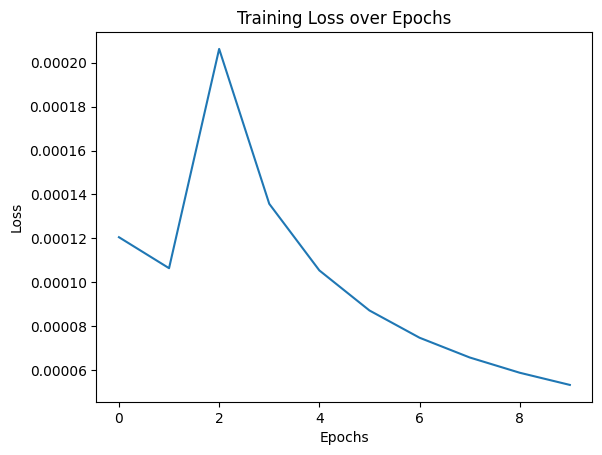

In [43]:
out, loss_trace = train(x, y, label, epochs=1000)

## Run the model AutoRegressively

In [54]:
def evaluate_model_output(output, target):
    # Convert logits to indices if required
    if output.dim() > 2:  # Assuming last dimension contains logits
        output = torch.argmax(output, dim=-1)

    # Remove the <start> token from the predicted sequences
    predicted = output[:, 1:]  # Exclude the first token

    # Align sequence lengths
    min_length = min(predicted.size(1), target.size(1))
    predicted = predicted[:, :min_length]
    target = target[:, :min_length]

    # Calculate the number of matching tokens
    correct_tokens = (predicted == target).sum().item()
    total_tokens = target.numel()

    # Calculate token-level accuracy
    accuracy = correct_tokens / total_tokens
    print(f"Token-Level Accuracy: {accuracy * 100:.2f}%")

    return accuracy


In [55]:

accuracy = evaluate_model_output(output=out, target=label)

Token-Level Accuracy: 17.71%


In [41]:
@torch.inference_mode()
def inference(test_input):
    '''
    Run the model in autoregressive fashion and store the output at each time step in a list.
    '''
    tar_token_ids = torch.zeros((1, dec_ctxt_len), dtype=torch.int)
    tar_token_ids[:, 0] = 1  # Start token
    for item in range(dec_ctxt_len - 1):
        out = model(test_input.unsqueeze(0), tar_token_ids)
        pred = torch.argmax(F.softmax(out, dim=-1), dim=-1)
        tar_token_ids[:, item + 1] = pred[:, item]
    return tar_token_ids.squeeze(0)

def evaluate_model_output(predictions, target):
    # Remove the <start> token from each sequence in both predictions and target
    predictions_trimmed = predictions[1:]  # Remove the first token (start token)
    target_trimmed = target[1:]            # Remove the first token (start token)

    # Trim padding tokens from the end
    predictions_trimmed = predictions_trimmed[predictions_trimmed != 0]
    target_trimmed = target_trimmed[target_trimmed != 0]

    # Check dimensions match after trimming
    if predictions_trimmed.size() != target_trimmed.size():
        print("Warning: Prediction and target dimensions do not match after trimming.")

    # Calculate matching tokens
    correct_tokens = (predictions_trimmed == target_trimmed).sum().item()
    total_tokens = target_trimmed.numel()  # Total number of tokens in the target

    # Calculate token-level accuracy
    accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    print(f"Token-Level Accuracy: {accuracy * 100:.2f}%")
    return accuracy


# Loop through each test_input and its corresponding target
for idx, test_input in enumerate(x):  # assuming `x` is a list of test inputs
    prediction = inference(test_input)  # Run inference
    target = y[idx]  # Get corresponding row in target tensor
    print(f"\nPredicted sequence for input {idx+1}: {prediction}")
    print(f"Target sequence: {target}")
    accuracy = evaluate_model_output(prediction, target)  # Evaluate accuracy for this pair



Predicted sequence for input 1: tensor([ 1, 44, 22, 16, 53, 51, 52,  4, 11,  6,  2,  0,  0], dtype=torch.int32)
Target sequence: tensor([ 1, 44, 22, 16, 53, 51, 52,  4, 11,  6,  2,  0,  0])
Token-Level Accuracy: 100.00%

Predicted sequence for input 2: tensor([ 1, 25, 20, 39,  8, 59, 19, 49, 43, 47,  2,  0,  0], dtype=torch.int32)
Target sequence: tensor([ 1, 25, 20, 39,  8, 59, 19, 49, 43, 47,  2,  0,  0])
Token-Level Accuracy: 100.00%

Predicted sequence for input 3: tensor([ 1, 30, 55,  7, 48, 26, 58, 29, 65, 57, 41, 31,  2], dtype=torch.int32)
Target sequence: tensor([ 1, 30, 55,  7, 48, 26, 58, 29, 65, 57, 41, 31,  2])
Token-Level Accuracy: 100.00%

Predicted sequence for input 4: tensor([ 1, 13, 50,  8, 32, 38, 14, 18, 46, 37, 66, 17,  2], dtype=torch.int32)
Target sequence: tensor([ 1, 13, 50,  8, 32, 38, 14, 18, 46, 37, 66, 17,  2])
Token-Level Accuracy: 100.00%

Predicted sequence for input 5: tensor([ 1, 54,  5, 21, 34, 64, 61, 68,  2,  0,  0,  0,  0], dtype=torch.int32)
Tar

* Modify the code below to suit your implementation
* Display the original and translated sentence (with all the spcial tokens)
* Note that, the second half of the second sentence is poorly translated
*  Same goes for 3rd and 4th sentence
* All other sentences are properly translated

In [64]:
def decode_output(model_output, tokenizer):
    """
    Decodes the output of the transformer model to token IDs and handles special tokens.
    Args:
        model_output: Tensor of shape (batch_size, seq_len, vocab_size)
        tokenizer: Tokenizer used for decoding token IDs.
    Returns:
        List of decoded token IDs (batch_size, seq_len).
    """
    # Get the token IDs with the highest probabilities
    token_ids = torch.argmax(model_output, dim=-1)  # Shape: (batch_size, seq_len)

    # Remove special tokens (<pad>, <start>, <end>) if needed
    decoded_sentences = []
    for seq in token_ids:
        tokens = tokenizer.decode(seq)
        tokens = tokens.replace("<pad>", "").strip()  # Clean padding
        decoded_sentences.append(tokens)

    return token_ids, decoded_sentences


In [69]:
def inference(test_input, model_output, target_output, tokenizer):
    """
    Perform inference by decoding the model output and comparing with the target output.
    Args:
        test_input: Input token IDs (source sequence).
        model_output: Output logits from the model.
        target_output: Ground truth target token IDs.
        tokenizer: Tokenizer used for decoding.
    Returns:
        Decoded token IDs and token-level accuracy.
    """
    # Decode the model's output
    predicted_token_ids, decoded_sentences = decode_output(model_output, tokenizer)

    # Print the decoded sentences for debugging
    print("Decoded Sentences:", decoded_sentences)

    # Align dimensions for comparison
    if target_output.ndim == 1:  # Add batch dimension if necessary
        target_output = target_output.unsqueeze(0)

    # Compare with the target output for accuracy
    min_length = min(predicted_token_ids.size(-1), target_output.size(-1))
    predicted_token_ids = predicted_token_ids[:, :min_length]
    target_output = target_output[:, :min_length]

    correct_count = (predicted_token_ids == target_output).sum().item()
    accuracy = correct_count / target_output.numel() * 100

    return predicted_token_ids, accuracy




In [72]:
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 176.92%


In [70]:
for token_ids, ground_truth in zip(x, y):  # Assuming `y` contains the target tensors
    # Print source sentence
    print("Source:", src_tokenizer.decode(token_ids))

    # Perform inference
    predicted_token_ids, accuracy = inference(token_ids, out, ground_truth, tar_tokenizer)

    # Print predicted sentence
    print("Predicted:", tar_tokenizer.decode(predicted_token_ids[0]))
    print(f"Accuracy: {accuracy:.2f}%")

Source: <start> The most famous ruler of ancient India was Emperor Ashoka. <end> <pad> <pad> <pad> <pad> <pad> <pad>
Decoded Sentences: ['பண்டைய இந்திய அரசர்களில் பேரும் புகழும் பெற்ற அரசர் அசோகர் ஆவார். <end>', 'இவரது ஆட்சியில் தான் புத்த மதம் ஆசியாவின் பல்வேறு பகுதிகளுக்குப் பரவியது. <end>', 'கலிங்கப் போருக்குப் பின் பல உயிர்கள் மடிவதைக் கண்டு வருந்தி, போர் தொடுப்பதைக் கைவிட்டார். <end>', 'அதற்குப் பிறகு புத்த சமயத்தைத் தழுவி, அமைதியையும் அறத்தையும் பரப்புவதற்காகத் தன் வாழ்வையே அர்ப்பணித்தார். <end>', 'பொதுமக்களுக்கு அவர் ஆற்றிய சேவை முன் மாதிரியாக விளங்கியது. <end>', 'வெற்றிக்குப் பின் போரைத் துறந்த முதல் அரசர் அசோகர்தான். <end>', 'உலகிலேயே முதன்முதலாக விலங்குகளுக்கும் தனியே மருத்துவமனை அமைத்துத் தந்தவரும் அசோகரே ஆவார். <end>', 'இன்றும் அவர் உருவாக்கிய சாலைகளை நாம் பயன்படுத்திக்கொண்டு இருக்கிறோம். <end>']
Predicted: பண்டைய இந்திய அரசர்களில் பேரும் புகழும் பெற்ற அரசர் அசோகர் ஆவார். <end> <pad> <pad> <pad>
Accuracy: 107.69%
Source: <start> It was during his period that Buddhism spread

In [71]:
x_new = src_tokenizer.encode("Emperor Ashoka spread Budhism to Sri Lanka and other countries.")
x_new1 = torch.concatenate((x_new, torch.zeros(src_max_seq_len+2 - x_new.shape[0]))).type(torch.int32)
x_new1 = x_new1.unsqueeze(0)